In [1]:
import random
import networkx as nx
from matplotlib import pyplot as plt
from collections import Counter
import math
from utils.plotTools import plot_qwak
import os
import ast
import numpy as np
import json
import pandas as pd
from sklearn.linear_model import LinearRegression

from scripts import load_list_from_file, write_list_to_file, load_or_generate_data, draw_graph, draw_graph_from_adjacency_matrix
from scripts_tempHelix import generate_static_temporal_helix, generate_temporal_helix, multiple_exponential_temporal_helix
from scripts_theoreticalHittingTime import create_transition_matrix

In [2]:
def print_matrix(matrix):
    # Print rows with left and right border
    for row in matrix:
        print('|', end='')
        print(' '.join(format(item, ".2f") for item in row), end=' |\n')
        
figsize = (15, 6)
k = 0.2
draw_self_loops = False

config = {
    'figsize': figsize,
    'k': k,
    'draw_self_loops': draw_self_loops,
    'node_color': 'orange',
    'node_size': 800,
    'normal_edge_color': 'blue',
    'normal_edge_width': 1.5,
    'edge_style': 'solid',
    'self_loop_color': 'red',
    'title': 'H_2_0'
}

config1 = {
    'figsize': figsize,
    'k': k,
    'draw_self_loops': draw_self_loops,
    'node_color': 'orange',
    'node_size': 800,
    'normal_edge_color': 'blue',
    'normal_edge_width': 1.5,
    'edge_style': 'solid',
    'self_loop_color': 'red',
    'title': 'H_2_1'
}

config2 = {
    'figsize': figsize,
    'k': k,
    'draw_self_loops': draw_self_loops,
    'node_color': 'orange',
    'node_size': 800,
    'normal_edge_color': 'blue',
    'normal_edge_width': 1.5,
    'edge_style': 'solid',
    'self_loop_color': 'red',
    'title': 'H_2_2'
}

config3 = {
    'figsize': figsize,
    'k': k,
    'draw_self_loops': draw_self_loops,
    'node_color': 'orange',
    'node_size': 800,
    'normal_edge_color': 'blue',
    'normal_edge_width': 1.5,
    'edge_style': 'solid',
    'self_loop_color': 'red',
    'title': 'H_2_3'
}

# New graph every step

In [3]:
def estimate_hitting_time(reps, start_vertex, end_vertex, num_simulations=10):
    """
    Estimate the hitting time between two vertices in a list of lollipop graphs.

    Parameters:
    m_values (list): The list of m values, each representing the number of vertices in the complete graph part of a lollipop graph.
    n_values (list): The list of n values, each representing the number of vertices in the path part of a lollipop graph.
    start_vertex (int): The starting vertex for the random walk.
    end_vertex (int): The target vertex for the random walk.
    num_simulations (int): The number of simulations to perform.

    Returns:
    hitting_times (list): A list of estimated average hitting times for each lollipop graph.
    """

    hitting_times = []

    for rep in range(1,reps+1):
        print(f'\nCalculatig hitting time for reps = {rep} ; n = {3+3*rep}')
        total_steps_for_all_simulations = 0

        # Create the lollipop graph
        graph = nx.from_numpy_array(generate_temporal_helix(rep,0))
        current_node = list(graph.nodes)[start_vertex]
        end_node = list(graph.nodes)[end_vertex]
        print(f'Starting node: {current_node} \t Neighbors: {list(nx.neighbors(graph,current_node))}')
        print(f'End node: {end_node} \t Neighbors: {list(nx.neighbors(graph,end_node))}')
        for s in range(num_simulations):
            if s == 0 or s == 1 or s % 5 == 0:
                print(f'----> Sample number:{s}')
                pass
            total_steps_this_simulation = 0
            current_node = list(graph.nodes)[start_vertex]
            # Loop continues until end_vertex is reached
            while current_node != end_node:
                # Choose a neighbor randomly
                graph = nx.from_numpy_array(generate_temporal_helix(rep,total_steps_this_simulation))
                neighbors = list(nx.neighbors(graph, current_node))
                if neighbors:
                    current_node = random.choice(neighbors)
                total_steps_this_simulation += 1
                # print(current_node)
                # print(end_node)
                # print()

            # Accumulate the total steps for this simulation
            total_steps_for_all_simulations += total_steps_this_simulation

        # Average the total steps over the number of simulations
        average_hitting_time = total_steps_for_all_simulations / num_simulations
        hitting_times.append(average_hitting_time)

    return hitting_times

def fit_hitting_time(reps,epsilon,factor):
    cover_times = []
    k = 0
    for n in range(1,reps+1):
        k = n**epsilon
        cover_times.append(2**(factor*k))
    return cover_times
       
    return hitting_times

def fit_hitting_time_2(reps,factor):
    cover_times = []
    k = 0
    for n in range(1,reps+1):
        cover_times.append(2**(factor*n))
    return cover_times
       
    return hitting_times


In [4]:
epsilon = 0.50

reps = 8
nrange2 = [3 + 3*rep for rep in range(1,reps)]
nrange3 = [3 + 3*rep for rep in range(1,reps+1)]
factor = 4.7

fromNode = 0
toNode = -1


samples = 20


hitting_times_file = f'Datasets/DynGraphsDTRW/hittingTimeV2TemporalHelix_N{nrange2[0]}-{nrange2[-1]}_EPS{epsilon}_S{samples}.txt'

if os.path.exists(hitting_times_file):
    hitting_times = load_list_from_file(hitting_times_file)
    estimate_hitting_time_memory = [x for x in fit_hitting_time(reps,epsilon,factor)]
    print('File exists!')
else:
    print('File Doesnt Exist!')
    hitting_times = estimate_hitting_time(reps,fromNode,toNode, num_simulations=samples)
    write_list_to_file(hitting_times_file, hitting_times)
    estimate_hitting_time_memory = [x for x in fit_hitting_time(reps,epsilon,factor)]

File exists!


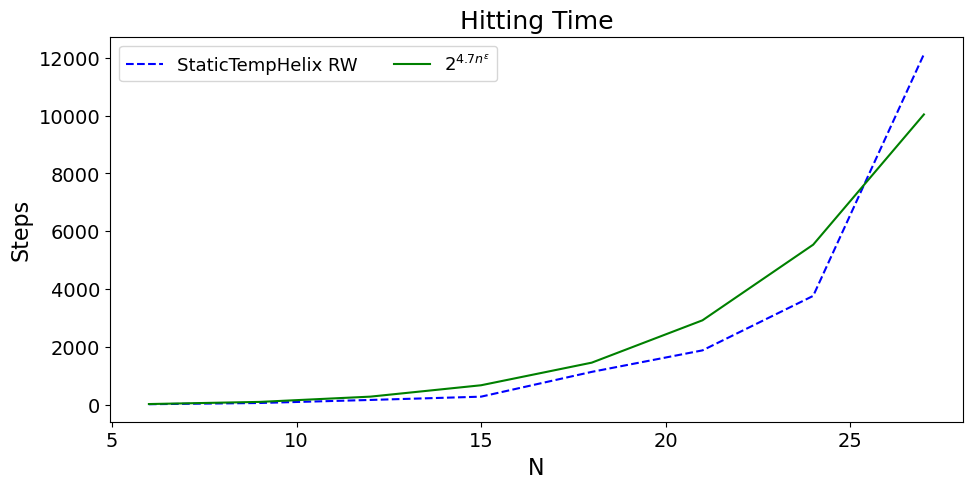

In [5]:
alphaLabelList = [r'StaticTempHelix RW',r'$2^{' +f'{factor}' +r'n^\epsilon}$']

params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252'],
    'line_style_list' : ['--', '-','-.' ],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    # 'x_num_ticks' : 7,
    # 'y_num_ticks' : 7,
    # 'x_round_val' : 1,
    # 'y_round_val' : 3,
}

plot_qwak(x_value_matrix = [list(nrange3),list(nrange3)] , y_value_matrix = [hitting_times,estimate_hitting_time_memory],**params)

## Fitting the model v1

In [6]:
nrange3 = [3 + 3*rep for rep in range(1,reps+1)]
# Use the modified function to generate the DataFrame
print(nrange3)
for i in range(1,reps+1):
    graph = nx.from_numpy_array(generate_temporal_helix(i,0))
    print(len(graph))

df = pd.DataFrame({
    'n': nrange3,
    'hitting_times': hitting_times
})

# Calculate the log-log values
df['log_n'] = np.log2(df['n'])
df['log_log_hitting_times'] = np.log2(np.log2(df['hitting_times']))

# Reshape data for sklearn
X = df['log_n'].values.reshape(-1,1)
Y = df['log_log_hitting_times'].values.reshape(-1,1)

# Create a linear regression model
model = LinearRegression()

# Fit the model
model.fit(X, Y)

# The coefficient in the model is the estimate of epsilon, and 2^intercept is the estimate of c
epsilon = model.coef_[0][0]
c = 2**model.intercept_[0]

print('c =', c)
print('epsilon =', epsilon)

[6, 9, 12, 15, 18, 21, 24, 27]
6
9
12
15
18
21
24
27
c = 1.1536703104816708
epsilon = 0.7405769429625857


C:\Users\jaime\Documents\GitHub\DTRandomWalk\scripts_tempHelix.py:57: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(G, nodelist=nodes).todense()
C:\Users\jaime\Documents\GitHub\DTRandomWalk\scripts_tempHelix.py:73: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(G, nodelist=nodes).todense()


In [7]:
import numpy as np
from scipy.optimize import curve_fit

def func(n, c, epsilon):
    return np.log(c) + epsilon * np.log(n) + np.log(np.log(2))

def fit_data(x_data, y_data):
    # Convert data to log-log space
    x_log = np.log(x_data)
    y_log_log = np.log(np.log(y_data))
    
    # Linear regression
    A = np.vstack([x_log, np.ones_like(x_log)]).T
    epsilon, ln_c_times_ln2 = np.linalg.lstsq(A, y_log_log, rcond=None)[0]
    
    c = np.exp(ln_c_times_ln2 - np.log(np.log(2)))
    
    return c, epsilon

x_data = nrange3  # replace with your x data
y_data = hitting_times  # replace with your y data

c_v1, epsilon_v1 = fit_data(x_data, y_data)
print(f"c: {c}, epsilon: {epsilon}")

c: 1.1536703104816708, epsilon: 0.7405769429625857


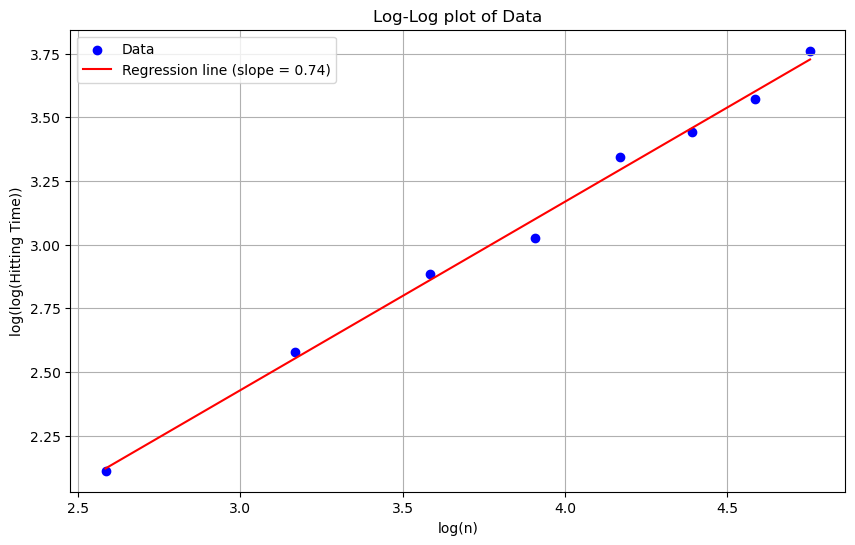

In [8]:
def plot_loglog(x_data, y_data):
    # Take the logarithm of your data
    log_x = np.log2(x_data)
    log_y = np.log2(np.log2(y_data))

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.scatter(log_x, log_y, color='blue', label='Data')

    # Add a regression line
    slope, intercept = np.polyfit(log_x, log_y, 1)
    plt.plot(log_x, slope*log_x + intercept, color='red', label=f'Regression line (slope = {slope:.2f})')

    # Add labels and legend
    plt.xlabel('log(n)')
    plt.ylabel('log(log(Hitting Time))')
    plt.title('Log-Log plot of Data')
    plt.legend()
    plt.grid(True)
    plt.show()

x_data = nrange3
y_data = hitting_times
# Assume x_data and y_data are your data
plot_loglog(x_data, y_data)

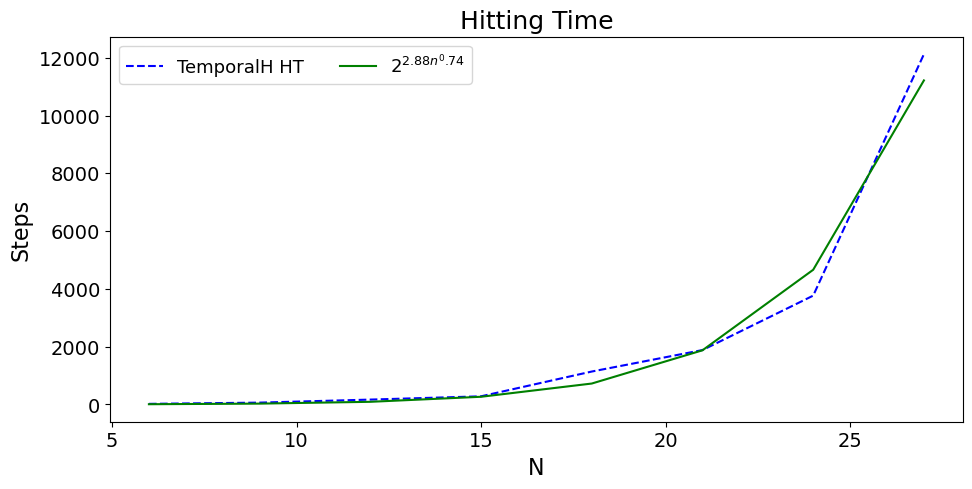

In [9]:
c = 2.5*c_v1
epsilon = epsilon_v1
fit_hitting_time = [x for x in fit_hitting_time(reps,epsilon,c)]

alphaLabelList = [r'TemporalH HT', '$2^{' + f'{round(c,2)}' + r'n^' + f'{round(epsilon,2)}' + r'}$']

params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252'],
    'line_style_list' : ['--', '-','-.' ],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    # 'x_num_ticks' : 7,
    # 'y_num_ticks' : 7,
    # 'x_round_val' : 1,
    # 'y_round_val' : 3,
}

plot_qwak(x_value_matrix = [list(nrange3),list(nrange3)] , y_value_matrix = [hitting_times,fit_hitting_time],**params)


## Fitting the model v2

In [10]:
# nrange3 = [3 + 3*rep for rep in range(1,reps+1)]
# # Use the modified function to generate the DataFrame
# print(nrange3)
# for i in range(1,reps+1):
#     graph = nx.from_numpy_array(generate_temporal_helix(i,0))
#     print(len(graph))

# df = pd.DataFrame({
#     'n': nrange3,
#     'hitting_times': hitting_times
# })

# # Calculate the log-log values
# df['log_n'] = np.log2(df['n'])
# df['log_log_hitting_times'] = np.log2(np.log2(df['hitting_times']))

# # Reshape data for sklearn
# X = df['log_n'].values.reshape(-1,1)
# Y = df['log_log_hitting_times'].values.reshape(-1,1)

# # Create a linear regression model
# model = LinearRegression()

# # Fit the model
# model.fit(X, Y)

# # The coefficient in the model is the estimate of epsilon, and 2^intercept is the estimate of c
# epsilon = model.coef_[0][0]
# c = 2**model.intercept_[0]

# print('c =', c)
# print('epsilon =', epsilon)


In [11]:
# import numpy as np
# from scipy.optimize import curve_fit

# def func(n, c, epsilon):
#     return np.log(c) + epsilon * np.log(n) + np.log(np.log(2))

# def fit_data(x_data, y_data):
#     # Convert data to log-log space
#     x_log = np.log2(x_data)
#     y_log_log = np.log2(np.log2(y_data))
    
#     # Linear regression
#     A = np.vstack([x_log, np.ones_like(x_log)]).T
#     epsilon, ln_c_times_ln2 = np.linalg.lstsq(A, y_log_log, rcond=None)[0]
    
#     c = np.exp(ln_c_times_ln2 - np.log(np.log(2)))
    
#     return c, epsilon

# x_data = nrange3  # replace with your x data
# y_data = hitting_times  # replace with your y data

# c, epsilon = fit_data(x_data, y_data)
# print(f"c: {c}, epsilon: {epsilon}")


In [12]:
# def plot_loglog(x_data, y_data):
#     # Take the natural logarithm of your data
#     log_x = np.log(x_data)
#     log_y = np.log(y_data)

#     # Create the plot
#     plt.figure(figsize=(10, 6))
#     plt.scatter(log_x, log_y, color='blue', label='Data')

#     # Add a regression line
#     slope, intercept = np.polyfit(log_x, log_y, 1)
#     plt.plot(log_x, slope*log_x + intercept, color='red', label=f'Regression line (slope = {slope:.2f})')
    
#     # Add labels and legend
#     plt.xlabel('log(n)')
#     plt.ylabel('log(log(Hitting Time))')
#     plt.title('Log-Log plot of Data')
#     plt.legend()
#     plt.grid(True)
#     plt.show()



# x_data = nrange3
# y_data = hitting_times
# # Assume x_data and y_data are your data
# plot_loglog(x_data, y_data)

In [13]:
# c = 1.7
# epsilon = 1

# fit2_hitting_time = [x for x in fit_hitting_time(reps,c)]

# alphaLabelList = [r'TemporalH HT', '$2^{' + f'{round(c,2)}' + r'n^' + f'{round(epsilon,2)}' + r'}$']

# params = {
#     'font_size' : 14,
#     'figsize': (11, 5),
#     'plot_title' : f'Hitting Time',
#     'x_label' : 'N',
#     'y_label' : "Steps",
#     'legend_labels' : alphaLabelList,
#     'legend_loc': "best",
#     # 'legend_title' : r'$\alpha$',
#     'legend_ncol' : 3,
#     'color_list' : ['#0000FF', '#008000', '#525252'],
#     'line_style_list' : ['--', '-','-.' ],
#     # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
#     'use_loglog': False,
#     'use_cbar' : False,
#     'cbar_label' : None, 
#     'cbar_ticks' : None,
#     'cbar_tick_labels' : None,
#     'x_lim' : None,
#     # 'x_num_ticks' : 7,
#     # 'y_num_ticks' : 7,
#     # 'x_round_val' : 1,
#     # 'y_round_val' : 3,
# }

# plot_qwak(x_value_matrix = [list(nrange3),list(nrange3)] , y_value_matrix = [hitting_times,fit2_hitting_time],**params)

#
# Theoretical Hitting Time - Szegedy

In [14]:
def theoretical_hitting_time(P1,P2,P3, q, z):
    """
    Calculate the expected hitting time to state z.

    Parameters:
    P (numpy.ndarray): Transition matrix.
    q (numpy.ndarray): Initial state distribution.
    z (int): Target state.

    Returns:
    float: Expected hitting time to state z from state q.
    """
    
    n = P1.shape[0]  # Number of states

    P1_minus_z, P2_minus_z, P3_minus_z = [P.copy() for P in [P1, P2, P3]]
    q_minus_z = q.copy()
    
    # Zeroing the row and column corresponding to z
    for P_minus_z in [P1_minus_z, P2_minus_z, P3_minus_z]:
        P_minus_z[z, :] = 0
        P_minus_z[:, z] = 0
        
    # Create the modified initial state distribution q_{-z}
    q_minus_z = q.copy()
    q_minus_z[z] = 0  # zero the element corresponding to z

    # Create the identity matrix
    I = np.eye(n)
    
    P_Dyn1 = np.dot(P2_minus_z,P1_minus_z) + P1_minus_z + I
    P_Dyn2 = np.linalg.inv(I - np.matmul(P3_minus_z,np.matmul(P2_minus_z,P1_minus_z)))
    
    P_Dyn = np.matmul(P_Dyn1,P_Dyn2)

    # Calculate the inverse of (I - P_{-z})
    # inv = np.linalg.inv(I - P_Dyn)

    # Calculate the expected hitting time from state q to state z
    h_z_q = np.dot(q_minus_z, np.dot(P_Dyn, np.ones(n)))

    return h_z_q

def hitting_times_for_tempHelix_graphs(reps, initIndex, target):
    hitting_times = []
    for rep in range(1,reps+1):
            G1 = nx.from_numpy_array(generate_temporal_helix(rep,0))
            G2 = nx.from_numpy_array(generate_temporal_helix(rep,1))
            G3 = nx.from_numpy_array(generate_temporal_helix(rep,2))
            init = np.zeros(len(G1))
            init[initIndex] = 1
            P1 = create_transition_matrix(G1)
            P2= create_transition_matrix(G2)
            P3 = create_transition_matrix(G3)
            hitting_time = theoretical_hitting_time(P1,P2,P3, init, target)
            hitting_times.append(hitting_time)
    return hitting_times


C:\Users\jaime\Documents\GitHub\DTRandomWalk\scripts_tempHelix.py:57: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(G, nodelist=nodes).todense()
C:\Users\jaime\Documents\GitHub\DTRandomWalk\scripts_tempHelix.py:73: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(G, nodelist=nodes).todense()


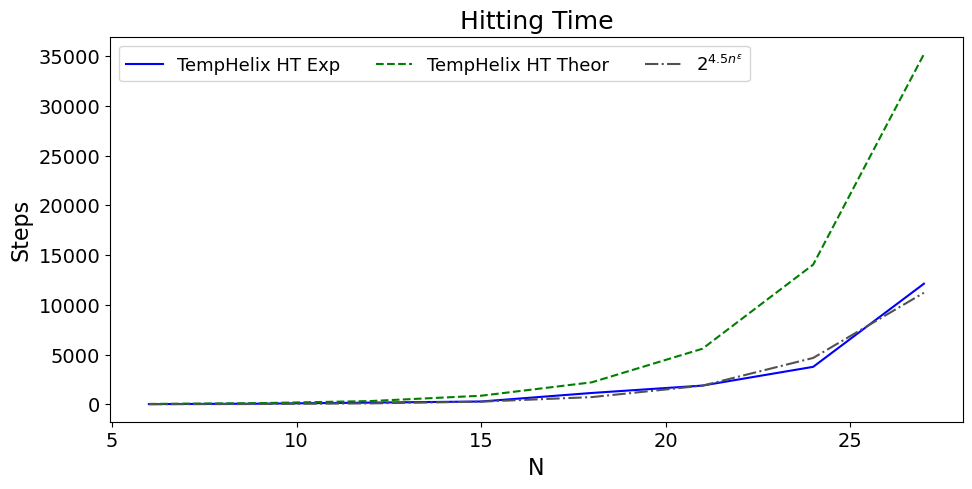

In [15]:
reps = 8
factor = 4.5
alphaLabelList = [r'TempHelix HT Exp',f'TempHelix HT Theor',r'$2^{' +f'{factor}' +r'n^\epsilon}$']

init = 0
target = -1

theoretical_hitting_times = hitting_times_for_tempHelix_graphs(reps, init, target)

params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252','#eb4034'],
    'line_style_list' : ['-', '--','-.',':' ],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    # 'x_num_ticks' : 7,
    # 'y_num_ticks' : 7,
    # 'x_round_val' : 1,
    # 'y_round_val' : 3,
}

plot_qwak(x_value_matrix = [list(nrange3)]*3 , y_value_matrix = [hitting_times,theoretical_hitting_times,fit_hitting_time],**params)

#
# Theoretical Hitting times v2 Korvi

In [16]:
def theoretical_hitting_time2(P1,P2,P3, init, target, steps):
    """
    Calculate the expected hitting time to state z.

    Parameters:
    P (numpy.ndarray): Transition matrix.
    q (numpy.ndarray): Initial state distribution.
    z (int): Target state.

    Returns:
    float: Expected hitting time to state z from state q.
    """
    
    n = P1.shape[0]  # Number of states
    print(n)

    # Create the modified transition matrix P_{-z}
    P1_prime = P1.copy()
    P2_prime = P2.copy()
    P3_prime = P3.copy()

    P1_prime[target,:] = 0
    P1_prime[target,target] = 1
    
    P2_prime[target,:] = 0
    P2_prime[target,target] = 1
    
    P3_prime[target,:] = 0
    P3_prime[target,target] = 1
    
    init_dist = np.zeros(n)
    init_dist[init] = 1
    
    target_dist = np.ones(n)
    target_dist[target] = 0
    target_dist = target_dist

    I = np.eye(n)
    
    P_prime_t = np.zeros((n,n))
    for t in range(0,steps):
        P_prime_t += np.linalg.matrix_power(np.matmul(P1_prime,
                                                      np.matmul(P2_prime,P3_prime)),
                                            t)
    
    P_prime = np.matmul( np.matmul(P1_prime,P2_prime)+P1_prime+I,
                        P_prime_t)
        
    hitting_time = np.dot(init_dist, np.dot(P_prime, target_dist))

    return hitting_time

def hitting_times_for_tempHelix_graphs2(reps, init, target,steps):
    hitting_times = []
    for rep in range(1,reps+1):
            G1 = nx.from_numpy_array(generate_temporal_helix(rep,0))
            G2 = nx.from_numpy_array(generate_temporal_helix(rep,1))
            G3 = nx.from_numpy_array(generate_temporal_helix(rep,2))
#             init = np.zeros(len(G1))
            P1 = create_transition_matrix(G1)
            P2= create_transition_matrix(G2)
            P3 = create_transition_matrix(G3)
            hitting_time = theoretical_hitting_time2(P1,P2,P3, init, target,steps)
            hitting_times.append(hitting_time)
    return hitting_times


#
# Theoretical Hitting Times v3 Korvi

In [17]:
def theoretical_hitting_time3(P1,P2,P3, init, target, steps):
    """
    Calculate the expected hitting time to state z.

    Parameters:
    P (numpy.ndarray): Transition matrix.
    q (numpy.ndarray): Initial state distribution.
    z (int): Target state.

    Returns:
    float: Expected hitting time to state z from state q.
    """
    
    n = P1.shape[0]  # Number of states
    print(n)
    
    P1_uu = P1[:target, :target]
    P2_uu = P2[:target, :target]
    P3_uu = P3[:target, :target]
    
    
#     print_matrix(P1)
#     print_matrix(P1_uu)
    
    init_dist = np.zeros(n-1)
    init_dist[init] = 1
    
    target_dist = np.ones(n-1)
    
    I = np.eye(n-1)

    P_uu_t = np.zeros((n-1,n-1))
    for t in range(0,steps):
        P_uu_t += np.linalg.matrix_power(np.matmul(P1_uu,
                                                      np.matmul(P2_uu,P3_uu)),
                                            t)
    
    P_uu = np.matmul( np.matmul(P1_uu,P2_uu)+P1_uu+I,
                        P_uu_t)
        
    hitting_time = np.dot(init_dist, np.dot(P_uu, target_dist))

    return hitting_time

def hitting_times_for_tempHelix_graphs3(reps, init, target,steps):
    hitting_times = []
    for rep in range(1,reps+1):
            G1 = nx.from_numpy_array(generate_temporal_helix(rep,0))
            G2 = nx.from_numpy_array(generate_temporal_helix(rep,1))
            G3 = nx.from_numpy_array(generate_temporal_helix(rep,2))
            P1 = create_transition_matrix(G1)
            P2= create_transition_matrix(G2)
            P3 = create_transition_matrix(G3)
            hitting_time = theoretical_hitting_time3(P1,P2,P3, init, target,steps)
            hitting_times.append(hitting_time)
    return hitting_times

In [18]:
reps = 8

init = 0
target = -1
steps = 20000

sum_range = []
sum_range = [3 + 3*rep for rep in range(1,reps+1)]
print(sum_range)

factor = 2
c = 0.85

theoretical_hitting_times_file3 = f'Datasets/DynGraphsDTRW/theoreticalHitting3TimeDynamicTempHelix_N{sum_range[-1]}_FROM{init}-TO{target}_STEPS{steps}.txt'

print(f'Looking for: \n-----> {theoretical_hitting_times_file3}')

if os.path.exists(theoretical_hitting_times_file3):
    theoretical_hitting_times3 = load_list_from_file(theoretical_hitting_times_file3)
    print('\nFile exists!')
else:
    print('\nFile Doesnt Exist!')
    theoretical_hitting_times3 =  hitting_times_for_tempHelix_graphs3(reps, init, target,steps)
    write_list_to_file(theoretical_hitting_times_file3, theoretical_hitting_times3)

[6, 9, 12, 15, 18, 21, 24, 27]
Looking for: 
-----> Datasets/DynGraphsDTRW/theoreticalHitting3TimeDynamicTempHelix_N27_FROM0-TO-1_STEPS20000.txt

File exists!


#
# Theoretical Hitting Times v4 Korvi

In [19]:
def theoretical_hitting_time4(P1,P2,P3, init, target):
    """
    Calculate the expected hitting time to state z.

    Parameters:
    P (numpy.ndarray): Transition matrix.
    q (numpy.ndarray): Initial state distribution.
    z (int): Target state.

    Returns:
    float: Expected hitting time to state z from state q.
    """
    
    n = P1.shape[0]  # Number of states
    
    P1_uu = P1[:target, :target]
    P2_uu = P2[:target, :target]
    P3_uu = P3[:target, :target]
    
    init_dist = np.zeros(n-1)
    init_dist[init] = 1
    
    target_dist = np.ones(n-1)
    
    I = np.eye(n-1)

    P_uu_inv = np.linalg.inv(I - np.matmul(P1_uu, 
                             np.matmul(P2_uu,P3_uu)))
    
    P_uu = np.matmul( np.matmul(P1_uu,P2_uu)+P1_uu+I, P_uu_inv)
        
    hitting_time = np.dot(init_dist, np.dot(P_uu, target_dist))

    return hitting_time

def hitting_times_for_tempHelix_graphs4(reps, init, target):
    hitting_times = []
    for rep in range(1,reps+1):
            G1 = nx.from_numpy_array(generate_temporal_helix(rep,0))
            G2 = nx.from_numpy_array(generate_temporal_helix(rep,1))
            G3 = nx.from_numpy_array(generate_temporal_helix(rep,2))
            P1 = create_transition_matrix(G1)
            P2= create_transition_matrix(G2)
            P3 = create_transition_matrix(G3)
            hitting_time = theoretical_hitting_time4(P1,P2,P3, init, target)
            hitting_times.append(hitting_time)
    return hitting_times

# reps = 42

# init = 0
# target = -1


# theoretical_hitting_times4 = hitting_times_for_tempHelix_graphs4(reps, init, target)
# plt.plot(theoretical_hitting_times4)

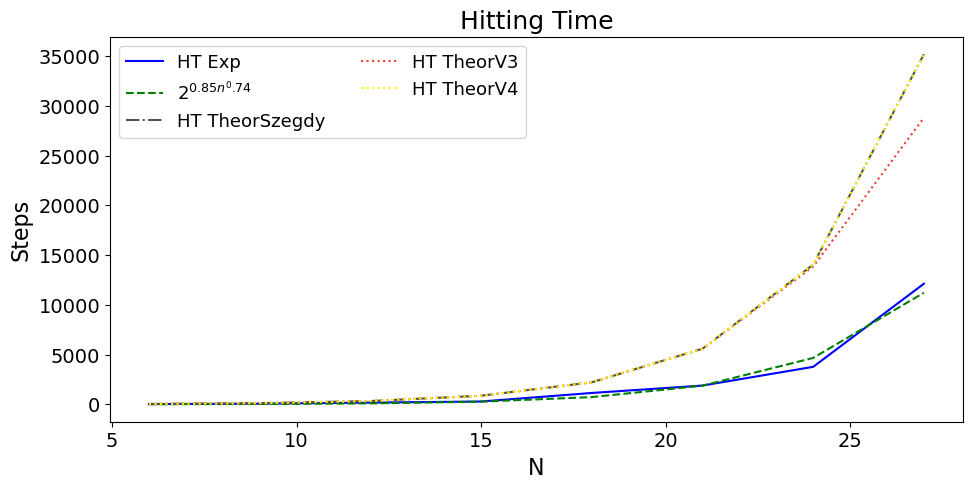

In [20]:
reps = 8

init = 0
target = -1


theoretical_hitting_times4 = hitting_times_for_tempHelix_graphs4(reps, init, target)

alphaLabelList = [r'HT Exp','$2^{' + f'{round(c,2)}' + r'n^' + f'{round(epsilon,2)}' + r'}$',f'HT TheorSzegdy',f'HT TheorV3',f'HT TheorV4']#,f'HT TheorV4',f'n^2',f'{round(c,2)}n^{factor}']

params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : len(alphaLabelList)//2,
    'color_list' : ['#0000FF', '#008000', '#525252','#eb4034','yellow','#8f82f1'],
    'line_style_list' : ['-', '--','-.',':',':','-.'],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    # 'x_num_ticks' : 7,
    # 'y_num_ticks' : 7,
    # 'x_round_val' : 1,
    # 'y_round_val' : 3,
}

y_value_list = [hitting_times,
                fit_hitting_time,
                theoretical_hitting_times,
                theoretical_hitting_times3,
                theoretical_hitting_times4]

plot_qwak(x_value_matrix = [list(sum_range)]*len(y_value_list) , y_value_matrix = y_value_list ,**params)